## Linear regression model
This notebook creates a linear regression model to predict house prices. The dataset used for this notebook is the Ames Housing dataset, which was compiled for data science by Dean De Cock. 

In [1]:
# import modules
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# adjust settings
%matplotlib inline

In [2]:
# get data
housing_df = pd.read_csv('housing_data.csv')

In [3]:
# examine data
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Examining the data

The dataset contains 80 variables. Much of the missing data is related to houses that do not posess certain housing attributes (Pool, Garage, Fence, Fireplace, etc.).

<font size="3"></font>


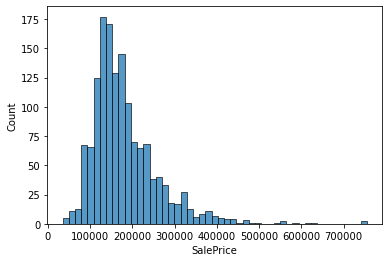

In [4]:
# examine distribution of the SalePrice variable
sns.histplot(housing_df['SalePrice'])
plt.show()

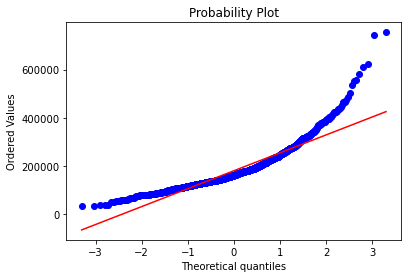

In [5]:
# examine probability plot of SalePrice variable
stats.probplot(housing_df['SalePrice'],plot=plt)
plt.show()

The SalePrice variable is positively skewed, transforming values will provide a more normal distribution.

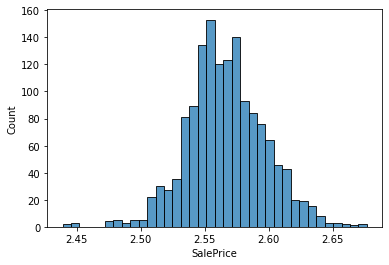

In [23]:
# create and examine a new column using logarithm of house prices
housing_df["SalePrice"] = np.log1p(housing_df["SalePrice"])
sns.histplot(housing_df["SalePrice"])
plt.show()

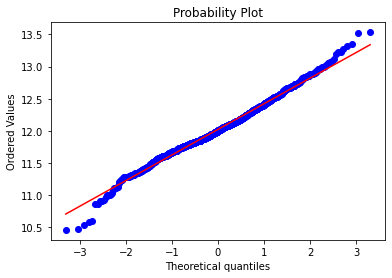

In [7]:
# examine probability plot of new SalePrice variable 
stats.probplot(housing_df['SalePrice'],plot=plt)
plt.show()

# Checking for outliers

In [8]:
# calculate z-scores
z = np.absolute(stats.zscore(housing_df['SalePrice']))
z[::-1].sort()
z[:10]

array([3.91619802, 3.8868792 , 3.78254409, 3.74915292, 3.70968802,
       3.61885071, 3.57463849, 3.30931612, 3.25527336, 3.13481798])

Despite several z-scores greater than 3, I decided against removing any records.

# Investigating correlation

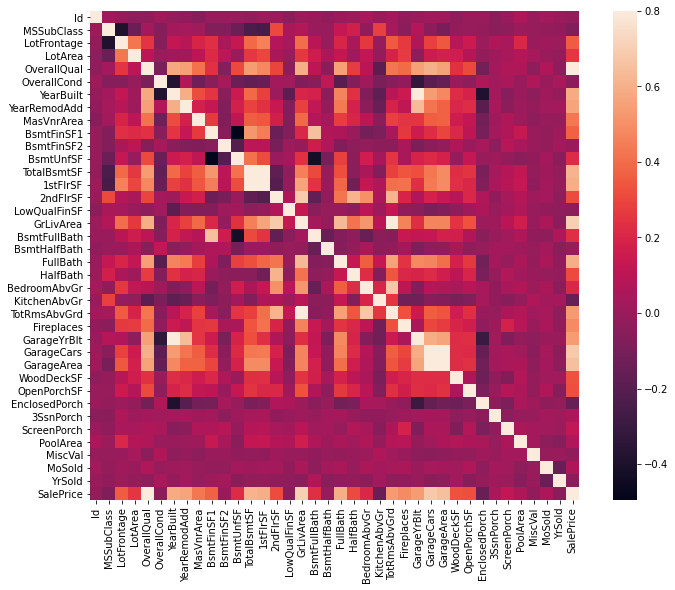

In [9]:
# examine correlations within the dataset
corrmat = housing_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

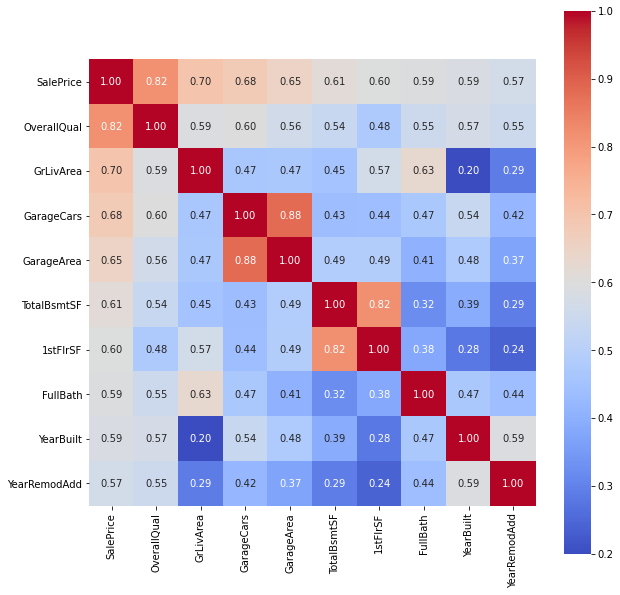

In [10]:
#examine 10 variables with highest correlation
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(housing_df[cols].values.T)
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(cm, cmap='coolwarm',cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The OverallQual variable (overall quality) possesses the highest correlation coefficient with SalePrice.

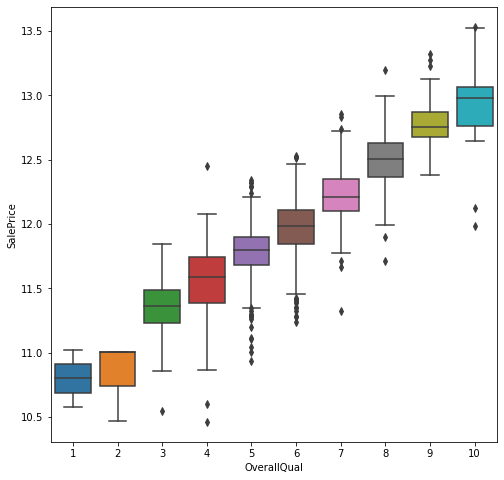

In [11]:
# examine boxplot of OverallQual and SalePrice variables
plt.figure(figsize=(8,8))
sns.boxplot(x='OverallQual',y='SalePrice',data=housing_df)
plt.show()

In [12]:
# remove variables that were not among 10 highest correlated with SalePrice varible
housing_df = housing_df[cols]

# Addressing multicollinearity

Several variables strongly correlated to the SalePrice variable are collinear. For Example, GarageArea and GarageCars possess a Pearson correlation coefficient of 0.88. I decided to remove the GarageCars, YearRemodAdd, FullBath and 1stFlrSF variables.

In [13]:
#remove collinear variables
housing_df = housing_df.drop(['GarageCars','YearRemodAdd','FullBath','1stFlrSF'],axis=1)

After removing collinear variables, the independent variables selected are:

- OverallQual - Overall Quality
- GrLivArea - Above Ground Living Area
- GarageArea - Garage Area
- TotalBsmtSF - Total Basement Square Feet
- YearBuilt - Construction Year

# Checking for missing values

In [14]:
# examine missing values
total = housing_df.isnull().sum().sort_values(ascending=False)
percent = (housing_df.isnull().sum()/housing_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
YearBuilt,0,0.0
TotalBsmtSF,0,0.0
GarageArea,0,0.0
GrLivArea,0,0.0
OverallQual,0,0.0
SalePrice,0,0.0


After removing variables that didn't show the strongest correlation with the SalePrice variable, there were no missing values to deal with.

# Examining final dataset

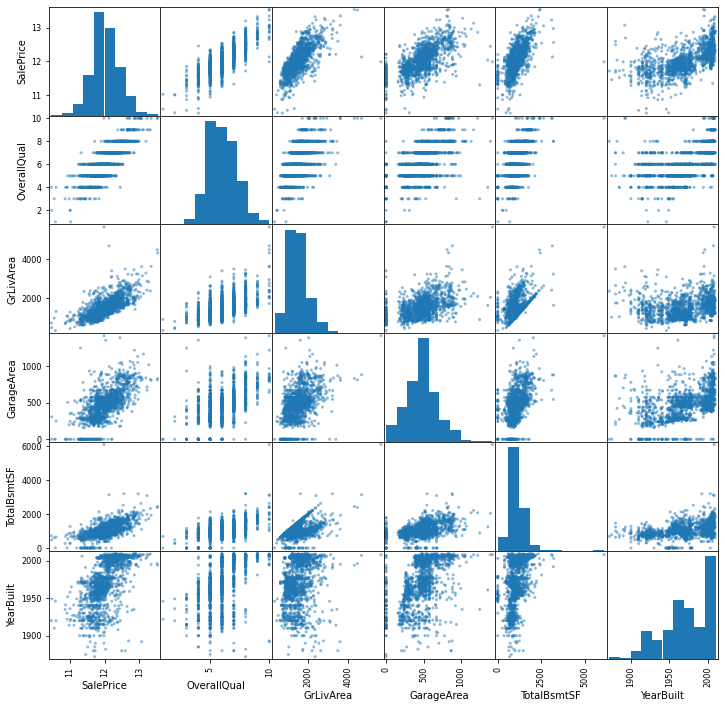

In [15]:
# plot scatter matrix of housing dataset
pd.plotting.scatter_matrix(housing_df,figsize=(12,12))
plt.show()

In [16]:
# examine housing dataset
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SalePrice    1460 non-null   float64
 1   OverallQual  1460 non-null   int64  
 2   GrLivArea    1460 non-null   int64  
 3   GarageArea   1460 non-null   int64  
 4   TotalBsmtSF  1460 non-null   int64  
 5   YearBuilt    1460 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 68.6 KB


# Splitting the data into training and test datasets
The data can be split into training and test datasets using the scikit-learn library, that library also provides tools to scale data.

In [17]:
# split housing dataset
housing_df_dropped = housing_df.drop('SalePrice',axis=1)
X_train, X_test, y_train, y_test = train_test_split(housing_df_dropped, housing_df['SalePrice'], test_size = 0.3,random_state=42) 


# scale the split data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Training the model

In [18]:
# fit linear regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

# Predicting house prices using test dataset

In [19]:
# predict SalePrice variable values for X_test
y_pred = regression_model.predict(X_test)

# show the first 5 predictions
y_pred[:5]

array([11.82502657, 12.64643874, 11.6365177 , 11.96255925, 12.63186688])

In [20]:
# reshape prediction Series and array of actual values
y_pred = y_pred.reshape(-1,1)
y_test = y_test.values.reshape(-1, 1)

In [21]:
# return R squared value for regression model
r2_score(y_test, y_pred)

0.8376424710226078

The model produced an R squared of 0.837, which means that 83% of  observed variation in the SalePrice variable is explained by the input variables selected for the linear regression model.

# Visualizing predictions

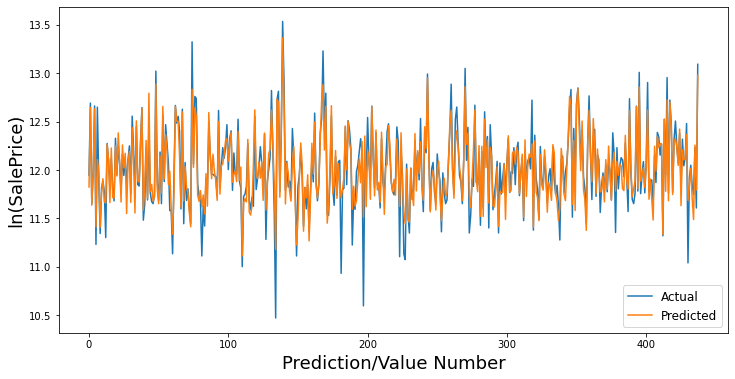

In [22]:
# plot predicted vs actual values for SalePrice variable
plt.figure(figsize=(12,6))
plt.xlabel("Prediction/Value Number", fontsize=18)
plt.ylabel("ln(SalePrice)", fontsize=18)
plt.plot(y_test,label="Actual")
plt.plot(y_pred,label="Predicted")
plt.legend(fontsize=12,loc="lower right")
plt.show()